Using device: cuda
Loading tokenizer...
Loading base model and adapter...
Model and tokenizer loaded successfully.
Dataset loaded. Initial number of samples: 5278
Dropping duplicate reactants...
Number of samples after dropping duplicate reactants: 4154
Generating embeddings for reactants...
Model and tokenizer loaded successfully.
Dataset loaded. Initial number of samples: 5278
Dropping duplicate reactants...
Number of samples after dropping duplicate reactants: 4154
Generating embeddings for reactants...


Embedding SMILES: 100%|██████████| 520/520 [00:23<00:00, 22.53it/s]



Embedding matrix shape: (4154, 768)
Computing silhouette scores in the original embedding space (768D)...
Overall silhouette score (cosine): -0.025
Silhouette score by reaction type (embedding space):
               mean_silhouette  samples
Reaction Type                          
Ha resonance             0.396       98
Resonance                0.013      124
Addition                -0.007      438
Recombine               -0.012     1221
Abstraction             -0.043     1174
Retroaddition           -0.044      212
Homolyze                -0.075      887
Applying UMAP for 2D dimensionality reduction...
Overall silhouette score (cosine): -0.025
Silhouette score by reaction type (embedding space):
               mean_silhouette  samples
Reaction Type                          
Ha resonance             0.396       98
Resonance                0.013      124
Addition                -0.007      438
Recombine               -0.012     1221
Abstraction             -0.043     1174
Retroaddition  

F:\code\anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embeddings shape: (4154, 2)
Computing minimum spanning tree...
Creating publication-quality visualization...
Publication-quality visualization saved to reaction_space_sci_publication.jpg
Publication-quality visualization saved to reaction_space_sci_publication.jpg


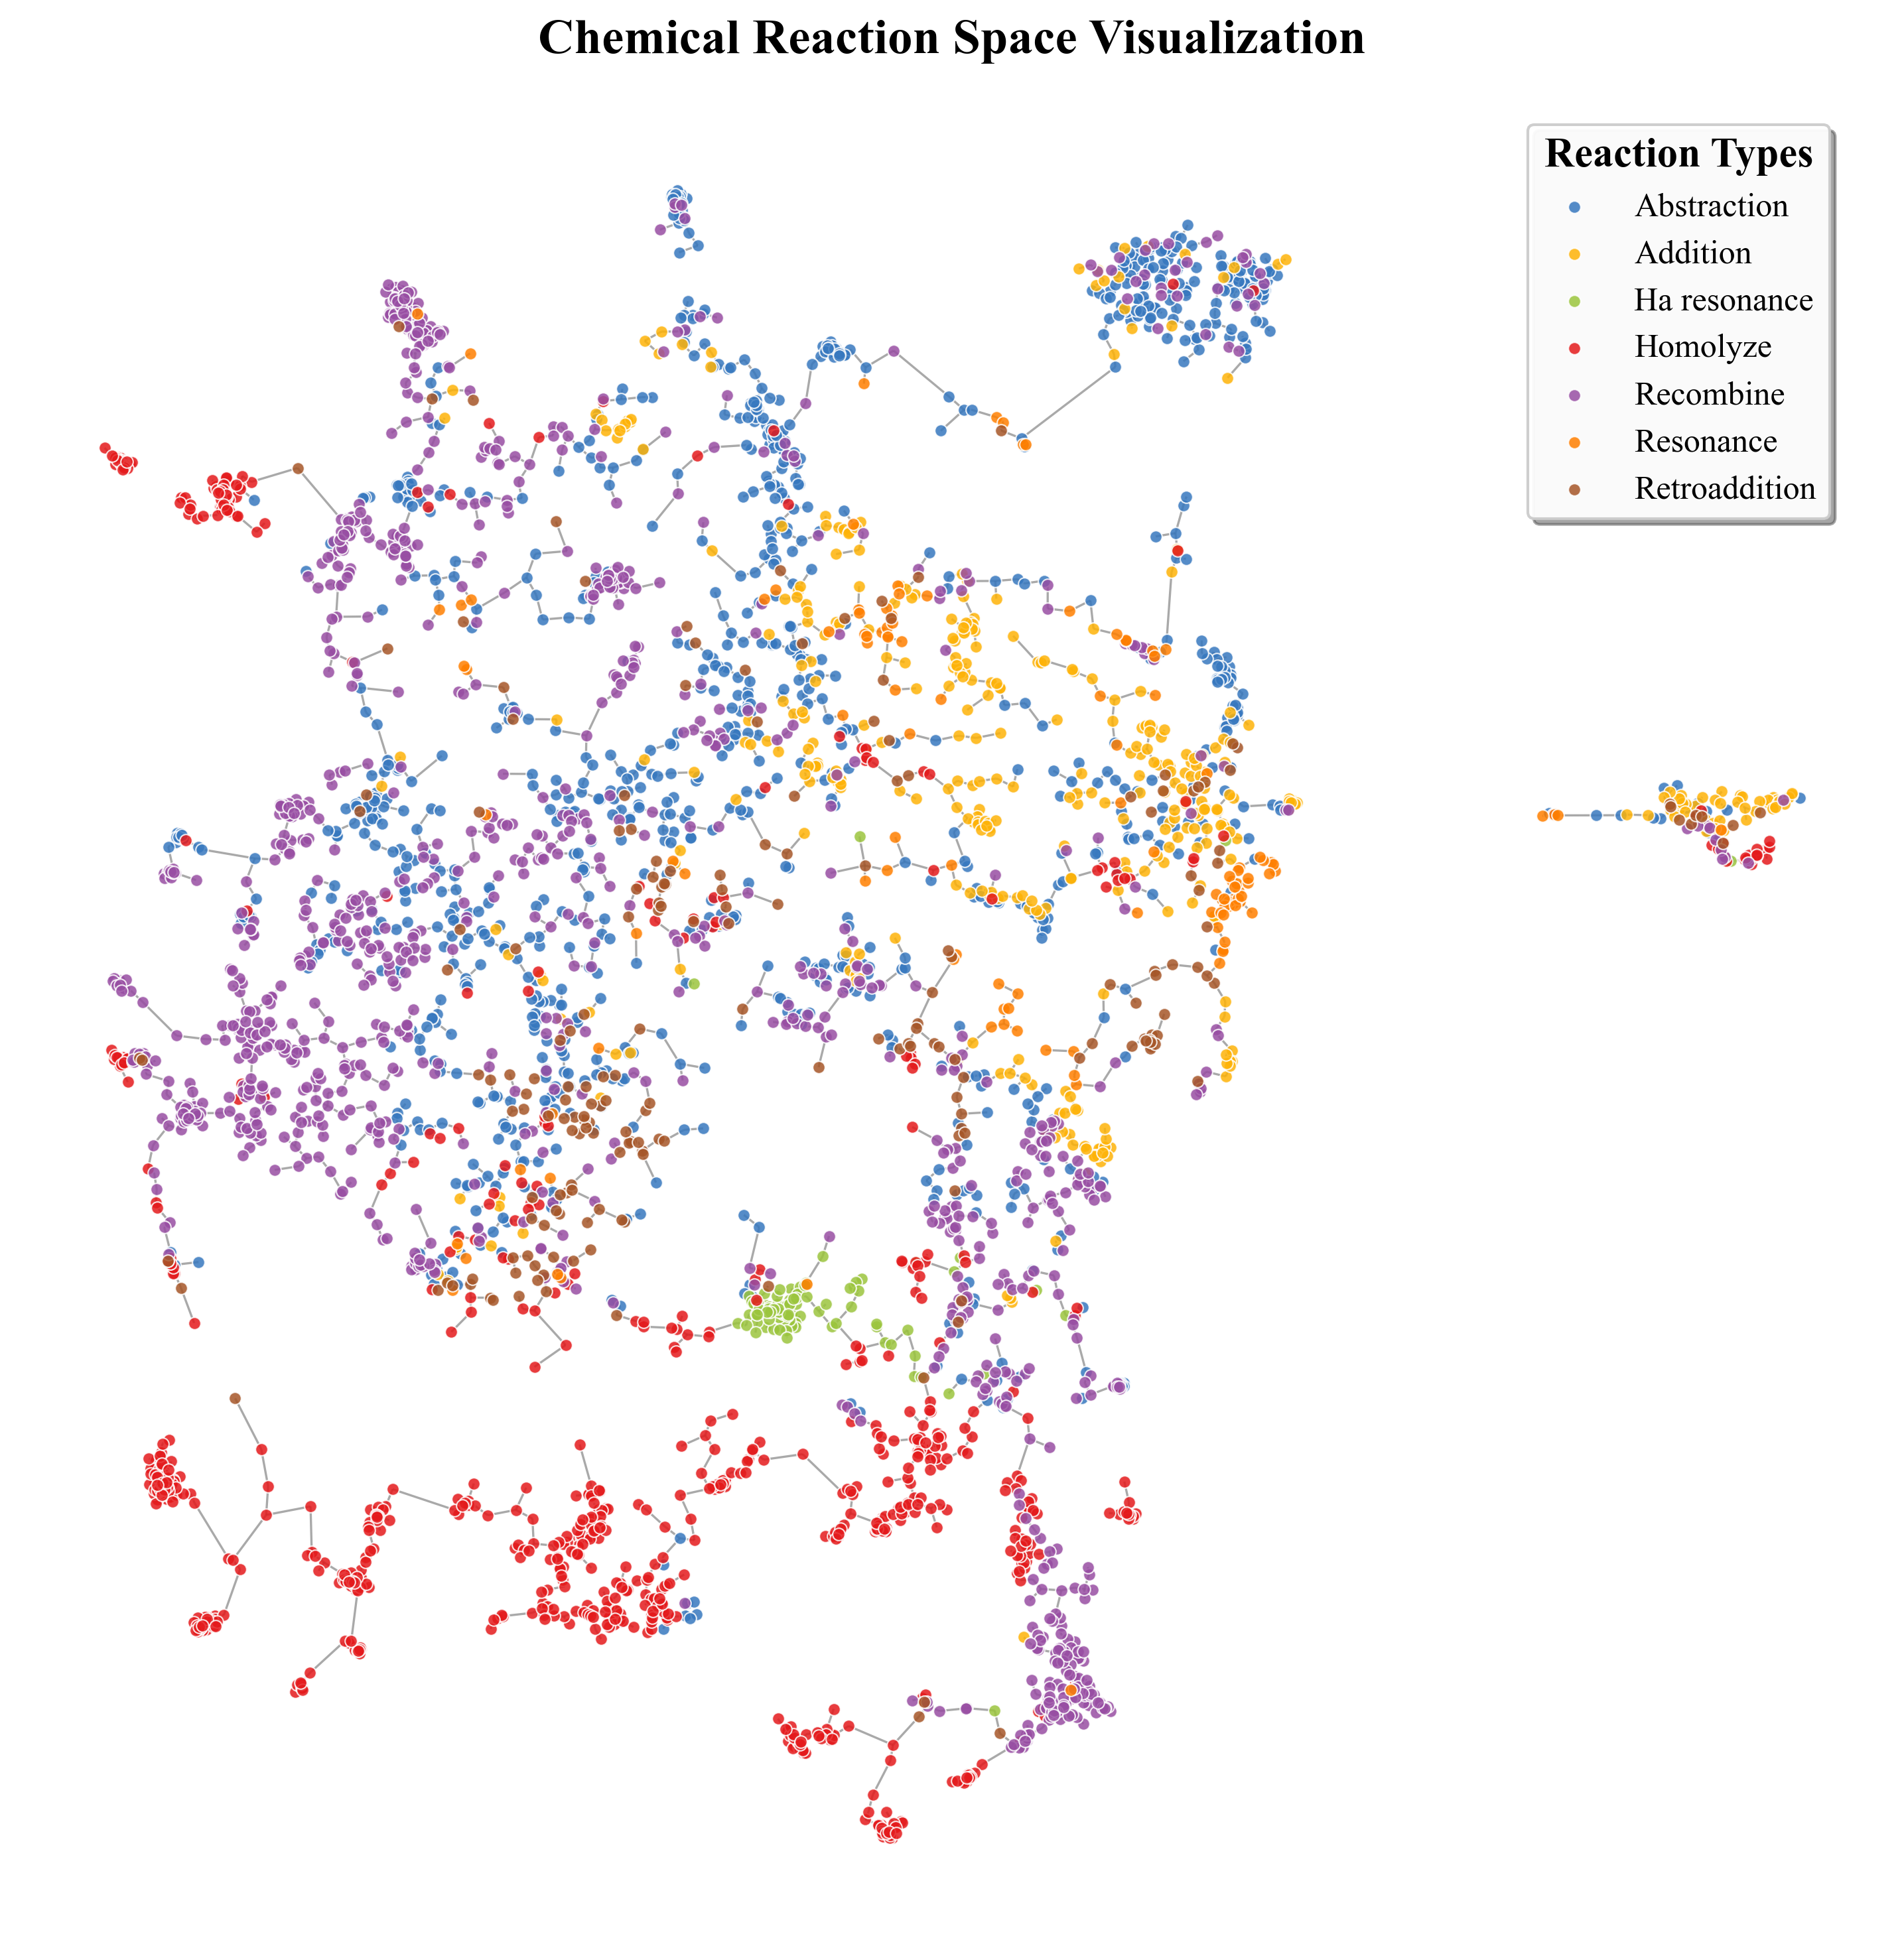

In [1]:
import os
import torch
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig
)
from datasets import load_from_disk, concatenate_datasets
from peft import PeftModel
import pandas as pd
from umap import UMAP
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.collections import LineCollection
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm
from matplotlib.colors import to_rgba
from adjustText import adjust_text

# --- Configuration ---
BASE_MODEL_NAME = "google/flan-t5-base"
ADAPTER_MODEL_PATH = "./best_model_multi_eval_v3_correct_loss/"
DATA_PATH = './data/data'
BATCH_SIZE = 8
MAX_SAMPLES = 5000
NEIGHBORS_K = 15  # MST的连接参数增加以获得更多树结构

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def main():
    # --- 加载模型部分保持不变 ---
    print("Loading tokenizer...")
    if not os.path.exists(ADAPTER_MODEL_PATH):
        raise FileNotFoundError(f"Adapter model path does not exist: {ADAPTER_MODEL_PATH}")
    tokenizer = AutoTokenizer.from_pretrained(ADAPTER_MODEL_PATH)

    print("Loading base model and adapter...")
    quantization_config_bnb = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16,
    )
    base_model = AutoModelForSeq2SeqLM.from_pretrained(
        BASE_MODEL_NAME, quantization_config=quantization_config_bnb, device_map={"": DEVICE}
    )
    base_model.resize_token_embeddings(len(tokenizer))

    model = PeftModel.from_pretrained(base_model, ADAPTER_MODEL_PATH)
    model.eval()
    model.to(DEVICE)

    model.config.bos_token_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.pad_token_id
    model.config.eos_token_id = tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.decoder_start_token_id = tokenizer.pad_token_id

    print("Model and tokenizer loaded successfully.")

    # --- 数据处理部分保持不变 ---
    dataset_dict = load_from_disk(DATA_PATH)
    combined_ds_hf = concatenate_datasets([dataset_dict["train"], dataset_dict['test']], axis=0)
    combined_ds = combined_ds_hf.to_pandas()
    print(f"Dataset loaded. Initial number of samples: {len(combined_ds)}")

    print("Dropping duplicate reactants...")
    combined_ds = combined_ds.drop_duplicates(subset=["reactant"]).reset_index(drop=True)
    print(f"Number of samples after dropping duplicate reactants: {len(combined_ds)}")

    if MAX_SAMPLES is not None and len(combined_ds) > MAX_SAMPLES:
        print(f"Subsampling dataset from {len(combined_ds)} to {MAX_SAMPLES} samples.")
        combined_ds = combined_ds.sample(n=MAX_SAMPLES, random_state=42).reset_index(drop=True)

    if combined_ds.empty:
        print("No data available after preprocessing. Exiting.")
        return

    # --- 生成嵌入向量部分保持不变 ---
    embeddings = []
    reactant_smiles_list = combined_ds['reactant'].tolist()

    print("Generating embeddings for reactants...")
    with torch.no_grad():
        for i in tqdm(range(0, len(reactant_smiles_list), BATCH_SIZE), desc="Embedding SMILES"):
            batch_smiles = [str(s) for s in reactant_smiles_list[i:i + BATCH_SIZE]]
            inputs = tokenizer(batch_smiles, return_tensors="pt", padding=True, truncation=True, max_length=512).to(DEVICE)
            encoder_outputs = model.encoder(**inputs)
            last_hidden_state = encoder_outputs.last_hidden_state
            attention_mask = inputs.attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_hidden_states = torch.sum(last_hidden_state * attention_mask, dim=1)
            sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
            pooled = sum_hidden_states / sum_mask
            embeddings.append(pooled.cpu())

    if not embeddings:
        raise ValueError("No embeddings were generated. Check your data and model.")
    embedding_matrix = torch.cat(embeddings, dim=0).numpy()
    print(f"Embedding matrix shape: {embedding_matrix.shape}")

    # --- 准备标签 ---
    labels_raw = [str(t).capitalize() for t in combined_ds['type'].tolist()]
    numerical_labels, unique_labels = pd.factorize(labels_raw, sort=True)
    n_labels = len(unique_labels)

    # --- 高维空间轮廓系数 ---
    print("Computing silhouette scores in the original embedding space (768D)...")
    if len(np.unique(numerical_labels)) > 1 and len(embedding_matrix) > len(np.unique(numerical_labels)):
        try:
            silhouette_values = silhouette_samples(embedding_matrix, numerical_labels, metric='cosine')
            overall_silhouette = silhouette_score(embedding_matrix, numerical_labels, metric='cosine')
            print(f"Overall silhouette score (cosine): {overall_silhouette:.3f}")
            silhouette_summary = (
                pd.DataFrame({"Reaction Type": labels_raw, "Silhouette": silhouette_values})
                .groupby("Reaction Type")
                .agg(mean_silhouette=("Silhouette", "mean"), samples=("Silhouette", "size"))
                .sort_values("mean_silhouette", ascending=False)
            )
            print("Silhouette score by reaction type (embedding space):")
            print(silhouette_summary.round(3).to_string())
        except Exception as exc:
            print(f"Silhouette computation failed: {exc}")
    else:
        print("Silhouette score skipped (insufficient label diversity).")

    # --- UMAP降维 ---
    print("Applying UMAP for 2D dimensionality reduction...")
    umap_reducer = UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
    umap_embeddings = umap_reducer.fit_transform(embedding_matrix)
    print(f"UMAP embeddings shape: {umap_embeddings.shape}")

    # --- 计算最小生成树 (MST) ---
    print("Computing minimum spanning tree...")
    # 基于欧氏距离构建K近邻图
    X = umap_embeddings

    # 构建KNN图
    knn_graph = kneighbors_graph(X, NEIGHBORS_K, mode='distance', include_self=False)

    # 计算最小生成树
    mst = minimum_spanning_tree(knn_graph)

    # 获取源点和目标点
    edges = []
    rows, cols = mst.nonzero()
    for i, j in zip(rows, cols):
        edges.append((i, j))

    # 创建可视化数据框
    plot_df = pd.DataFrame({
        'UMAP1': umap_embeddings[:, 0],
        'UMAP2': umap_embeddings[:, 1],
        'Reaction Type': labels_raw,
        'SMILES': combined_ds['reactant'].tolist()
    })

    # --- 设置科学论文级别的可视化 ---
    print("Creating publication-quality visualization...")

    # 设置matplotlib参数，使图形更适合学术发表
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'font.size': 15,
        'axes.linewidth': 1.5,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.frameon': True,
        'legend.framealpha': 0.9,
        'savefig.dpi': 300,  # 高DPI以获得清晰图像
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

    # 创建适合出版物的配色方案
    # 使用Science/Nature风格的配色方案
    colors = ['#3778bf', '#feb308', '#9bc53d', '#e41a1c', '#984ea3',
              '#ff7f00', '#a65628', '#f781bf', '#999999', '#4daf4a',
              '#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
              '#ffff33', '#a65628', '#f781bf', '#dede00']

    # 确保有足够的颜色
    while len(colors) < n_labels:
        colors.extend(colors)
    colors = colors[:n_labels]

    # 创建颜色映射
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    # 创建大尺寸图
    fig, ax = plt.subplots(figsize=(12, 10), dpi=300)

    # 首先绘制MST树的边 - 使用从深色到浅色的渐变
    lines = []
    for i, j in edges:
        lines.append([(X[i, 0], X[i, 1]), (X[j, 0], X[j, 1])])

    # 使用LineCollection绘制线条，可以一次设置所有线条的属性
    lc = LineCollection(lines, colors='#555555', linewidths=0.8, alpha=0.5, zorder=1)
    ax.add_collection(lc)

    # 为每种反应类型分别绘制点
    for reaction_type in unique_labels:
        indices = [idx for idx, rt in enumerate(labels_raw) if rt == reaction_type]

        if not indices:
            continue

        ax.scatter(
            plot_df.loc[indices, 'UMAP1'],
            plot_df.loc[indices, 'UMAP2'],
            s=20,  # 增大点的尺寸
            color=color_map[reaction_type],
            edgecolor='white',  # 白边使点更清晰
            linewidth=0.5,
            alpha=0.85,
            label=reaction_type,
            zorder=2
        )

    # 移除坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])

    # 设置更好的标题和标签
    ax.set_title('Chemical Reaction Space Visualization', fontsize=18, fontweight='bold', pad=20)
    # ax.set_xlabel('UMAP Dimension 1', fontsize=14, labelpad=10)
    # ax.set_ylabel('UMAP Dimension 2', fontsize=14, labelpad=10)

    # 添加好看的图例，但放在图外以避免遮挡
    legend = ax.legend(
        title='Reaction Types',
        bbox_to_anchor=(0.8, 1),
        loc='upper left',
        frameon=True,
        framealpha=0.95,
        edgecolor='#cccccc',
        fancybox=True,
        shadow=True,
        ncol=1
    )
    legend.get_title().set_fontweight('bold')

    # 添加反应空间的轮廓边界，增强专业感
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # 设置图像比例，确保x和y使用相同的比例
    ax.set_aspect('equal')

    # 适当调整以显示所有数据
    plt.tight_layout()

    # 保存为高质量JPG
    jpg_filename = "reaction_space_sci_publication.jpg"
    plt.savefig(jpg_filename, format='jpg', dpi=600, bbox_inches='tight')
    print(f"Publication-quality visualization saved to {jpg_filename}")


    # 显示图像
    plt.show()

if __name__ == '__main__':
    main()

Using device: cuda
Loading tokenizer...
Loading base model and adapter...
Model and tokenizer loaded successfully.
Dataset loaded. Initial number of samples: 5278
Dropping duplicate reactants...
Number of samples after dropping duplicate reactants: 4154
Model and tokenizer loaded successfully.
Dataset loaded. Initial number of samples: 5278
Dropping duplicate reactants...
Number of samples after dropping duplicate reactants: 4154
Generating embeddings for reactants...
Generating embeddings for reactants...


Embedding SMILES: 100%|██████████| 520/520 [00:09<00:00, 52.70it/s]



Embedding matrix shape: (4154, 768)
Generating predictions and checking accuracy...


Predicting: 100%|██████████| 4154/4154 [31:47<00:00,  2.18it/s] 
F:\code\anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(

F:\code\anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Applying UMAP for 2D dimensionality reduction...
UMAP embeddings shape: (4154, 2)
Computing minimum spanning tree...

Overall Top-5 Accuracy: 97.11%

Accuracy by Reaction Type:
                sum  count      mean
Reaction Type                       
Abstraction    1135   1174  0.966780
Addition        409    438  0.933790
Ha resonance     98     98  1.000000
Homolyze        880    887  0.992108
Recombine      1205   1221  0.986896
Resonance       121    124  0.975806
Retroaddition   186    212  0.877358

Saving data to chemical_space_data.pkl...
✓ Data saved successfully!

ANALYZING DENSE VS SPARSE REGIONS

Dense Region Accuracy: 97.35% (n=2077)
Sparse Region Accuracy: 96.87% (n=2077)

Contingency Table:
Correct  False  True 
Region               
Dense       55   2022
Sparse      65   2012

Chi-square test:
  χ² = 0.6951
  p-value = 4.0444e-01
  Degrees of freedom = 1
  ✗ No significant difference (p >= 0.05)

ANALYZING MOLECULAR FINGERPRINT SIMILARITY
Computing molecular fingerprint

Fingerprints: 100%|██████████| 4154/4154 [00:00<00:00, 18017.52it/s]



Computing neighborhood similarities...
Computing random pair similarities...


Random pairs: 100%|██████████| 5000/5000 [00:00<00:00, 15741.49it/s]




Metric                         Neighborhood    Random         
------------------------------------------------------------
Mean Similarity                0.3263          0.1034         
Median Similarity              0.3211          0.0872         
Std Similarity                 0.1397          0.0805         

Mann-Whitney U test (neighborhood > random):
  U statistic = 19193343.00
  p-value = 0.0000e+00
  ✓ Neighborhood similarity is significantly higher (p < 0.05)

✓ Similarity data added to chemical_space_data.pkl

CREATING VISUALIZATION
Visualization saved to reaction_space_with_accuracy.jpg
Visualization saved to reaction_space_with_accuracy.jpg


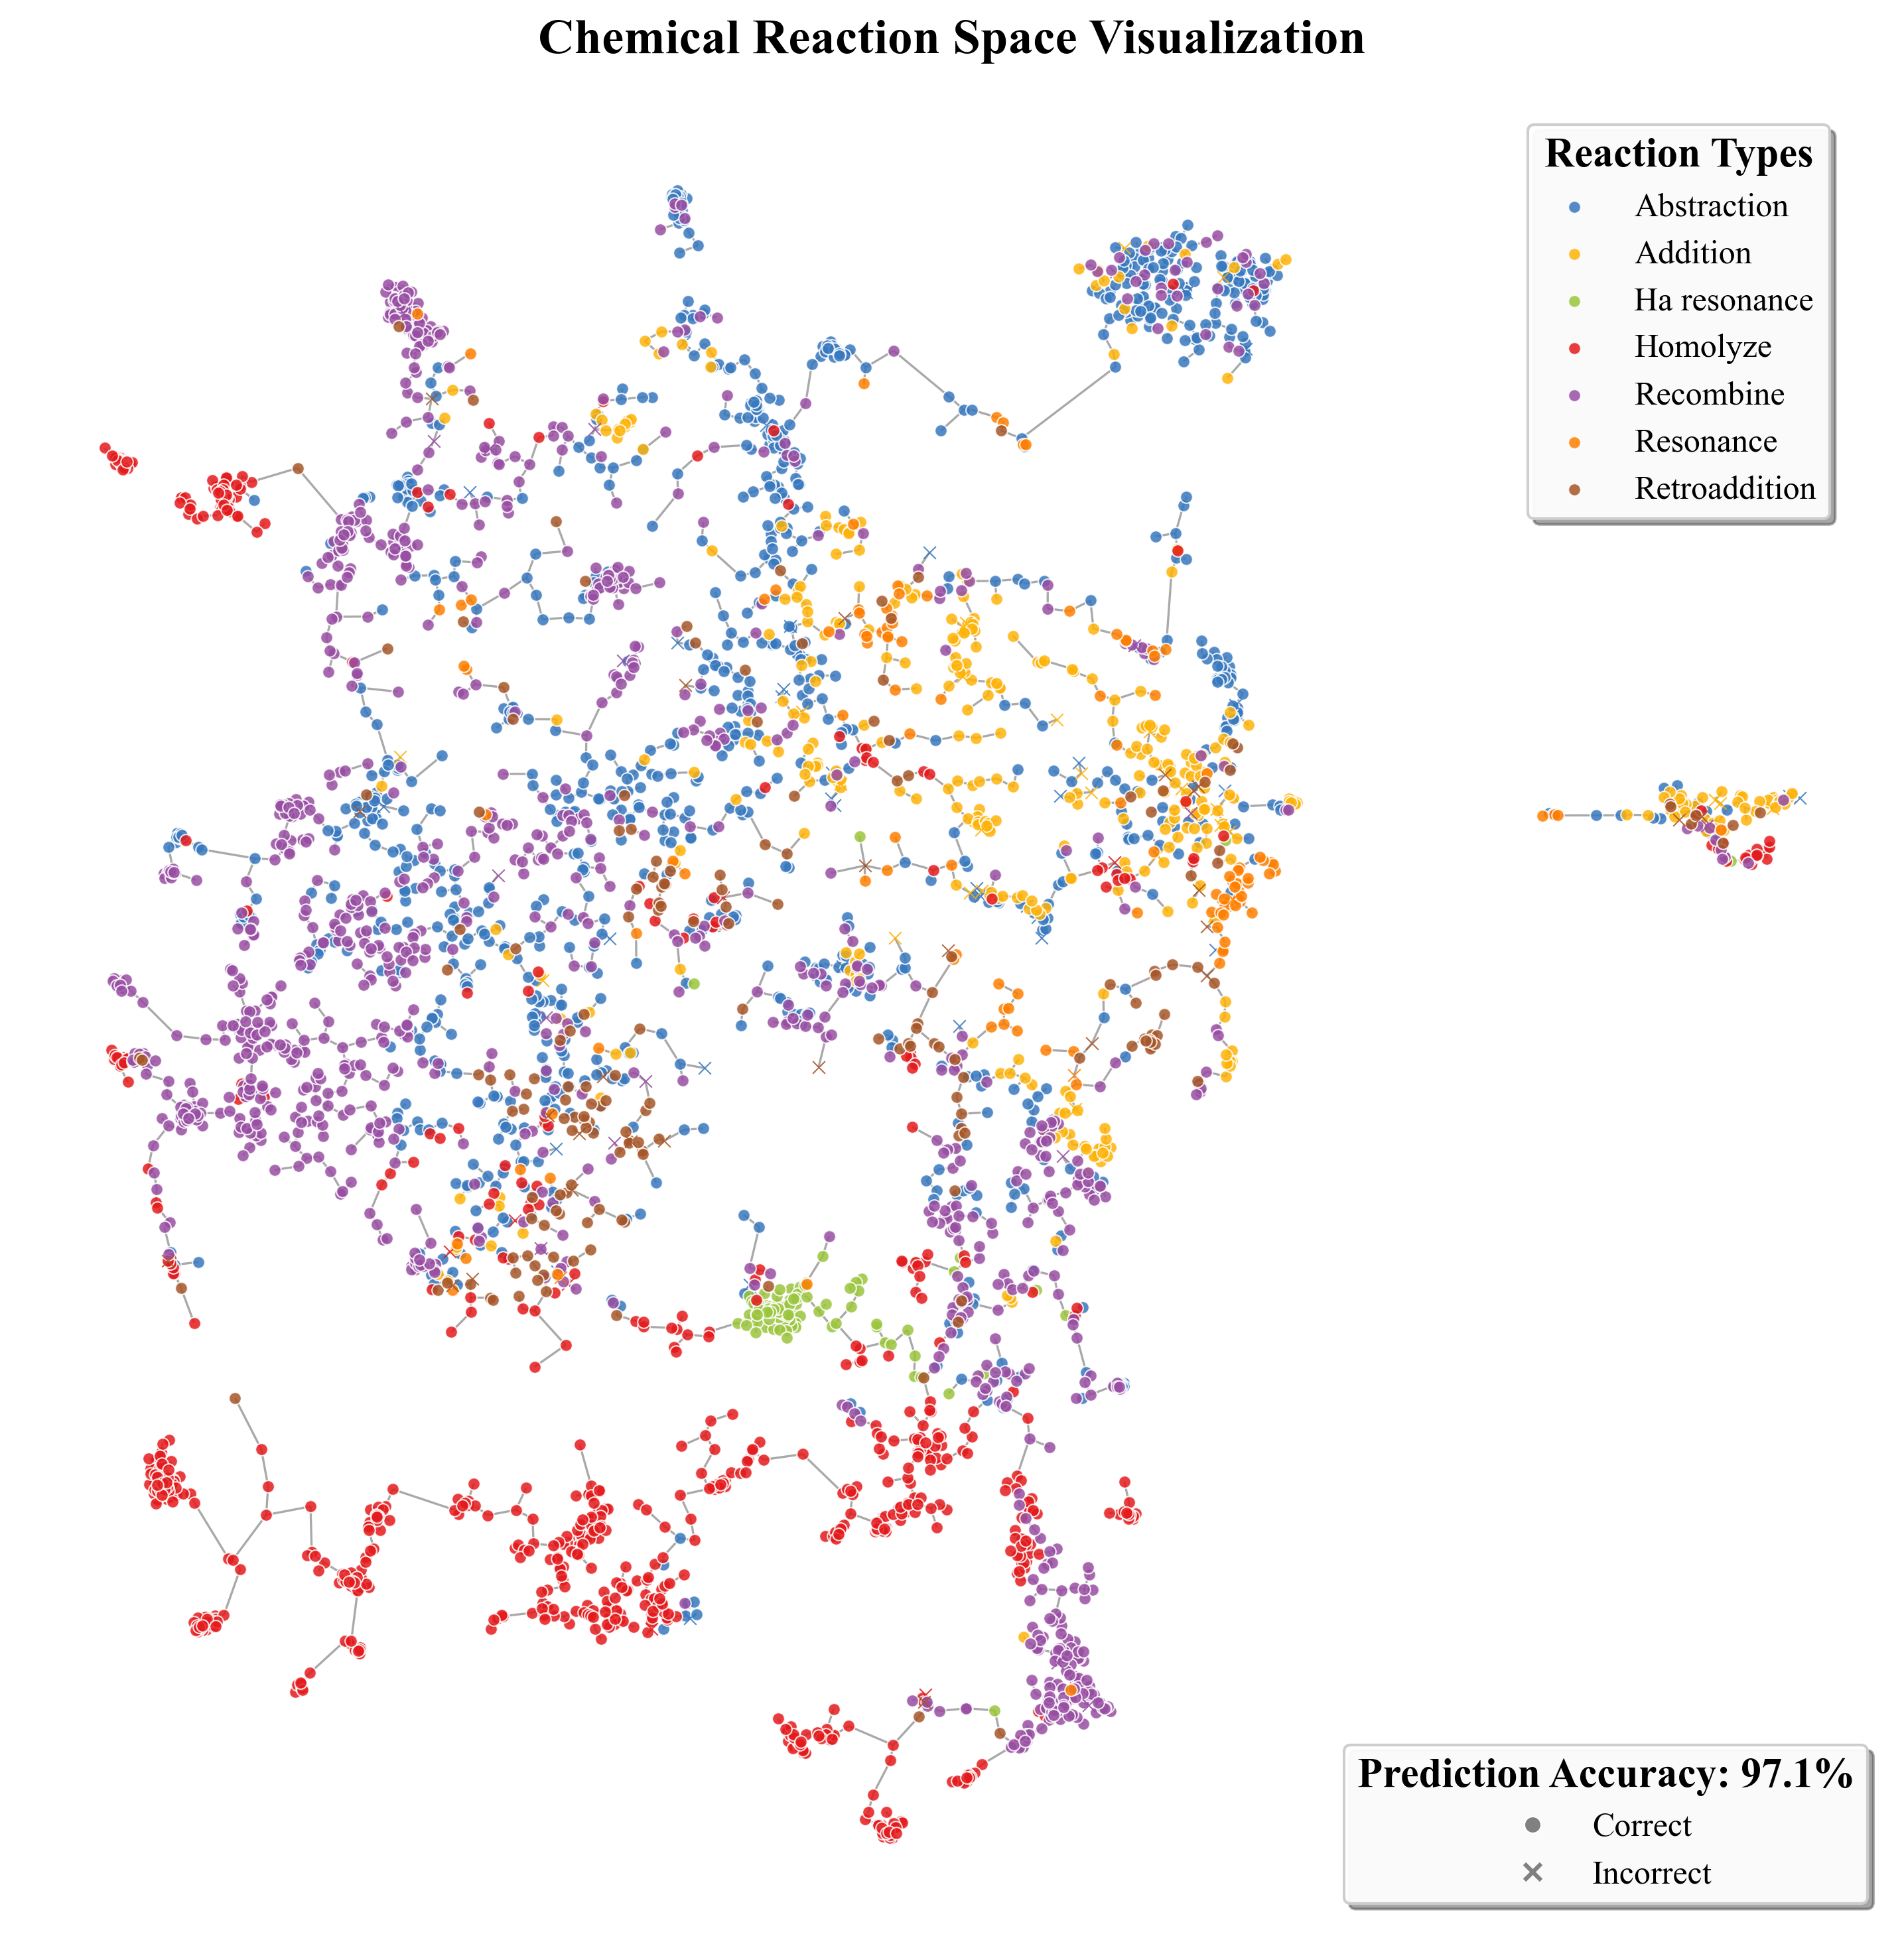


ANALYSIS COMPLETE!


In [4]:
import os
import torch
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig
)
from datasets import load_from_disk, concatenate_datasets
from peft import PeftModel
import pandas as pd
from umap import UMAP
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.stats import chi2_contingency, mannwhitneyu
import pickle
import gc

try:
    from rdkit import Chem
    from rdkit.Chem import AllChem
    from rdkit import RDLogger
    RDLogger.DisableLog('rdApp.*')
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("RDKit not found. Will use string-based comparison.")

# --- Configuration ---
BASE_MODEL_NAME = "google/flan-t5-base"
ADAPTER_MODEL_PATH = "./best_model_multi_eval_v3_correct_loss/"
DATA_PATH = './data/data'
BATCH_SIZE = 8
MAX_SAMPLES = 5000
NEIGHBORS_K = 15
NUM_RETURN_SEQUENCES = 5
MAX_LENGTH_GENERATION = 256
NUM_BEAMS = 10
SAVE_DATA_FILE = "chemical_space_data.pkl"  # 保存数据的文件

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Helper Functions ---
def canonicalize_smiles_rdkit(smiles: str, sanitize=True) -> str:
    if not RDKIT_AVAILABLE or not smiles or not isinstance(smiles, str):
        return str(smiles).strip() if isinstance(smiles, str) else ""
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=sanitize)
        if mol: return Chem.MolToSmiles(mol, canonical=True)
        return smiles.strip()
    except Exception:
        if sanitize:
            try:
                mol_no_sanitize = Chem.MolFromSmiles(smiles, sanitize=False)
                if mol_no_sanitize:
                    Chem.SanitizeMol(mol_no_sanitize, catchErrors=True)
                    return Chem.MolToSmiles(mol_no_sanitize, canonical=True)
            except Exception: pass
        return smiles.strip()

def check_prediction_match(predicted_smiles: str, true_products_set: set) -> bool:
    """Check if prediction matches any true product"""
    if not predicted_smiles or not isinstance(predicted_smiles, str):
        return False
    standardized_pred = canonicalize_smiles_rdkit(predicted_smiles)
    if not standardized_pred:
        return False
    return standardized_pred in true_products_set

def compute_molecular_fingerprint(smiles: str, radius=2, nBits=2048):
    """计算分子指纹"""
    if not RDKIT_AVAILABLE:
        return None
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        return fp
    except:
        return None

def tanimoto_similarity(fp1, fp2):
    """计算Tanimoto相似度"""
    if fp1 is None or fp2 is None:
        return 0.0
    return AllChem.DataStructs.TanimotoSimilarity(fp1, fp2)

def main():
    # --- 加载模型 ---
    print("Loading tokenizer...")
    if not os.path.exists(ADAPTER_MODEL_PATH):
        raise FileNotFoundError(f"Adapter model path does not exist: {ADAPTER_MODEL_PATH}")
    tokenizer = AutoTokenizer.from_pretrained(ADAPTER_MODEL_PATH)

    print("Loading base model and adapter...")
    quantization_config_bnb = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16,
    )
    base_model = AutoModelForSeq2SeqLM.from_pretrained(
        BASE_MODEL_NAME, quantization_config=quantization_config_bnb, device_map={"": DEVICE}
    )
    base_model.resize_token_embeddings(len(tokenizer))

    model = PeftModel.from_pretrained(base_model, ADAPTER_MODEL_PATH)
    model.eval()
    model.to(DEVICE)

    model.config.bos_token_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.pad_token_id
    model.config.eos_token_id = tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.decoder_start_token_id = tokenizer.pad_token_id

    print("Model and tokenizer loaded successfully.")

    # --- 数据处理 ---
    dataset_dict = load_from_disk(DATA_PATH)
    combined_ds_hf = concatenate_datasets([dataset_dict["train"], dataset_dict['test']], axis=0)
    combined_ds = combined_ds_hf.to_pandas()
    print(f"Dataset loaded. Initial number of samples: {len(combined_ds)}")

    print("Dropping duplicate reactants...")
    combined_ds = combined_ds.drop_duplicates(subset=["reactant"]).reset_index(drop=True)
    print(f"Number of samples after dropping duplicate reactants: {len(combined_ds)}")

    if MAX_SAMPLES is not None and len(combined_ds) > MAX_SAMPLES:
        print(f"Subsampling dataset from {len(combined_ds)} to {MAX_SAMPLES} samples.")
        combined_ds = combined_ds.sample(n=MAX_SAMPLES, random_state=42).reset_index(drop=True)

    if combined_ds.empty:
        print("No data available after preprocessing. Exiting.")
        return

    # 准备true products映射
    true_products_lookup = {}
    for idx, row in combined_ds.iterrows():
        reactant = str(row['reactant']).strip()
        product = str(row['product']).strip()
        if reactant not in true_products_lookup:
            true_products_lookup[reactant] = set()
        true_products_lookup[reactant].add(canonicalize_smiles_rdkit(product))

    # --- 生成嵌入向量 ---
    embeddings = []
    reactant_smiles_list = combined_ds['reactant'].tolist()

    print("Generating embeddings for reactants...")
    with torch.no_grad():
        for i in tqdm(range(0, len(reactant_smiles_list), BATCH_SIZE), desc="Embedding SMILES"):
            batch_smiles = [str(s) for s in reactant_smiles_list[i:i + BATCH_SIZE]]
            inputs = tokenizer(batch_smiles, return_tensors="pt", padding=True, truncation=True, max_length=512).to(DEVICE)
            encoder_outputs = model.encoder(**inputs)
            last_hidden_state = encoder_outputs.last_hidden_state
            attention_mask = inputs.attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_hidden_states = torch.sum(last_hidden_state * attention_mask, dim=1)
            sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
            pooled = sum_hidden_states / sum_mask
            embeddings.append(pooled.cpu())

    if not embeddings:
        raise ValueError("No embeddings were generated. Check your data and model.")
    embedding_matrix = torch.cat(embeddings, dim=0).numpy()
    print(f"Embedding matrix shape: {embedding_matrix.shape}")

    # --- 生成预测并检查准确性 ---
    print("Generating predictions and checking accuracy...")
    prediction_accuracy = []
    
    for i in tqdm(range(len(reactant_smiles_list)), desc="Predicting"):
        reactant_smiles = str(reactant_smiles_list[i])
        true_products = true_products_lookup.get(reactant_smiles, set())
        
        try:
            inputs = tokenizer(reactant_smiles, return_tensors="pt", max_length=MAX_LENGTH_GENERATION, truncation=True)
            input_ids = inputs.input_ids.to(DEVICE)
            attention_mask = inputs.attention_mask.to(DEVICE)
            
            with torch.no_grad():
                outputs = model.generate(
                    input_ids=input_ids, 
                    attention_mask=attention_mask,
                    max_length=MAX_LENGTH_GENERATION, 
                    num_return_sequences=NUM_RETURN_SEQUENCES,
                    num_beams=NUM_BEAMS, 
                    do_sample=False,
                    early_stopping=True, 
                    eos_token_id=model.config.eos_token_id,
                    pad_token_id=model.config.pad_token_id,
                    decoder_start_token_id=model.config.decoder_start_token_id,
                )
            
            generated_ids = outputs
            raw_predictions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            
            is_correct = any(check_prediction_match(pred, true_products) for pred in raw_predictions)
            prediction_accuracy.append(is_correct)
            
            del input_ids, attention_mask, outputs
            
        except Exception as e:
            print(f"Error predicting for reactant {i}: {e}")
            prediction_accuracy.append(False)
        
        gc.collect()
        if DEVICE.type == 'cuda': 
            torch.cuda.empty_cache()

    # --- 准备标签 ---
    labels_raw = [str(t).capitalize() for t in combined_ds['type'].tolist()]
    numerical_labels, unique_labels = pd.factorize(labels_raw, sort=True)
    n_labels = len(unique_labels)

    # --- UMAP降维 ---
    print("Applying UMAP for 2D dimensionality reduction...")
    umap_reducer = UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
    umap_embeddings = umap_reducer.fit_transform(embedding_matrix)
    print(f"UMAP embeddings shape: {umap_embeddings.shape}")

    # --- 计算最小生成树 (MST) ---
    print("Computing minimum spanning tree...")
    X = umap_embeddings
    knn_graph = kneighbors_graph(X, NEIGHBORS_K, mode='distance', include_self=False)
    mst = minimum_spanning_tree(knn_graph)

    edges = []
    rows, cols = mst.nonzero()
    for i, j in zip(rows, cols):
        edges.append((i, j))

    # 创建可视化数据框
    plot_df = pd.DataFrame({
        'UMAP1': umap_embeddings[:, 0],
        'UMAP2': umap_embeddings[:, 1],
        'Reaction Type': labels_raw,
        'SMILES': combined_ds['reactant'].tolist(),
        'Correct': prediction_accuracy
    })

    # --- 统计准确率 ---
    overall_accuracy = sum(prediction_accuracy) / len(prediction_accuracy) * 100
    print(f"\nOverall Top-5 Accuracy: {overall_accuracy:.2f}%")
    
    accuracy_by_type = plot_df.groupby('Reaction Type')['Correct'].agg(['sum', 'count', 'mean'])
    print("\nAccuracy by Reaction Type:")
    print(accuracy_by_type)

    # === 保存数据到文件 ===
    print(f"\nSaving data to {SAVE_DATA_FILE}...")
    data_to_save = {
        'plot_df': plot_df,
        'X': X,
        'edges': edges,
        'unique_labels': unique_labels,
        'labels_raw': labels_raw,
        'prediction_accuracy': prediction_accuracy,
        'n_labels': n_labels,
        'reactant_smiles_list': reactant_smiles_list,
        'overall_accuracy': overall_accuracy
    }
    with open(SAVE_DATA_FILE, 'wb') as f:
        pickle.dump(data_to_save, f)
    print(f"✓ Data saved successfully!")

    # === Dense/Sparse 区域分析 ===
    print("\n" + "="*60)
    print("ANALYZING DENSE VS SPARSE REGIONS")
    print("="*60)
    
    # 计算每个点的局部密度（使用k近邻距离的倒数）
    nbrs = NearestNeighbors(n_neighbors=10, metric='euclidean').fit(X)
    distances, indices = nbrs.kneighbors(X)
    local_density = 1.0 / (distances.mean(axis=1) + 1e-9)  # 平均距离的倒数作为密度
    
    # 根据密度中位数划分Dense和Sparse区域
    density_median = np.median(local_density)
    is_dense = local_density > density_median
    
    plot_df['Density'] = local_density
    plot_df['Region'] = ['Dense' if d else 'Sparse' for d in is_dense]
    
    # 计算Dense和Sparse区域的准确率
    dense_accuracy = plot_df[plot_df['Region'] == 'Dense']['Correct'].mean() * 100
    sparse_accuracy = plot_df[plot_df['Region'] == 'Sparse']['Correct'].mean() * 100
    
    print(f"\nDense Region Accuracy: {dense_accuracy:.2f}% (n={sum(is_dense)})")
    print(f"Sparse Region Accuracy: {sparse_accuracy:.2f}% (n={sum(~is_dense)})")
    
    # 卡方检验
    contingency_table = pd.crosstab(plot_df['Region'], plot_df['Correct'])
    print("\nContingency Table:")
    print(contingency_table)
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square test:")
    print(f"  χ² = {chi2:.4f}")
    print(f"  p-value = {p_value:.4e}")
    print(f"  Degrees of freedom = {dof}")
    if p_value < 0.05:
        print(f"  ✓ Significant difference (p < 0.05)")
    else:
        print(f"  ✗ No significant difference (p >= 0.05)")

    # === 分子指纹相似性分析 ===
    print("\n" + "="*60)
    print("ANALYZING MOLECULAR FINGERPRINT SIMILARITY")
    print("="*60)
    
    if RDKIT_AVAILABLE:
        # 计算所有分子的指纹
        print("Computing molecular fingerprints...")
        fingerprints = [compute_molecular_fingerprint(smi) for smi in tqdm(reactant_smiles_list, desc="Fingerprints")]
        
        # 计算每个点与其5个最近邻居的平均相似度
        print("Computing neighborhood similarities...")
        k_neighbors = 5
        nbrs_fp = NearestNeighbors(n_neighbors=k_neighbors+1, metric='euclidean').fit(X)
        distances_fp, indices_fp = nbrs_fp.kneighbors(X)
        
        neighborhood_similarities = []
        for i in range(len(fingerprints)):
            if fingerprints[i] is None:
                neighborhood_similarities.append(np.nan)
                continue
            
            neighbor_indices = indices_fp[i][1:]  # 排除自己
            similarities = []
            for neighbor_idx in neighbor_indices:
                if fingerprints[neighbor_idx] is not None:
                    sim = tanimoto_similarity(fingerprints[i], fingerprints[neighbor_idx])
                    similarities.append(sim)
            
            if similarities:
                neighborhood_similarities.append(np.mean(similarities))
            else:
                neighborhood_similarities.append(np.nan)
        
        neighborhood_similarities = np.array(neighborhood_similarities)
        valid_neighborhood = neighborhood_similarities[~np.isnan(neighborhood_similarities)]
        
        # 随机配对相似度
        print("Computing random pair similarities...")
        n_random_pairs = 5000
        random_similarities = []
        np.random.seed(42)
        
        valid_fps = [(i, fp) for i, fp in enumerate(fingerprints) if fp is not None]
        
        for _ in tqdm(range(n_random_pairs), desc="Random pairs"):
            idx1, idx2 = np.random.choice(len(valid_fps), size=2, replace=False)
            fp1 = valid_fps[idx1][1]
            fp2 = valid_fps[idx2][1]
            sim = tanimoto_similarity(fp1, fp2)
            random_similarities.append(sim)
        
        random_similarities = np.array(random_similarities)
        
        # 统计比较
        print(f"\n{'Metric':<30} {'Neighborhood':<15} {'Random':<15}")
        print("-" * 60)
        print(f"{'Mean Similarity':<30} {np.mean(valid_neighborhood):<15.4f} {np.mean(random_similarities):<15.4f}")
        print(f"{'Median Similarity':<30} {np.median(valid_neighborhood):<15.4f} {np.median(random_similarities):<15.4f}")
        print(f"{'Std Similarity':<30} {np.std(valid_neighborhood):<15.4f} {np.std(random_similarities):<15.4f}")
        
        # Mann-Whitney U检验
        statistic, p_value_mw = mannwhitneyu(valid_neighborhood, random_similarities, alternative='greater')
        print(f"\nMann-Whitney U test (neighborhood > random):")
        print(f"  U statistic = {statistic:.2f}")
        print(f"  p-value = {p_value_mw:.4e}")
        if p_value_mw < 0.05:
            print(f"  ✓ Neighborhood similarity is significantly higher (p < 0.05)")
        else:
            print(f"  ✗ No significant difference (p >= 0.05)")
        
        # 保存相似度数据
        data_to_save['neighborhood_similarities'] = neighborhood_similarities
        data_to_save['random_similarities'] = random_similarities
        with open(SAVE_DATA_FILE, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f"\n✓ Similarity data added to {SAVE_DATA_FILE}")
    else:
        print("RDKit not available. Skipping fingerprint analysis.")

    # === 可视化 ===
    print("\n" + "="*60)
    print("CREATING VISUALIZATION")
    print("="*60)
    
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'font.size': 15,
        'axes.linewidth': 1.5,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.frameon': True,
        'legend.framealpha': 0.9,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

    colors = ['#3778bf', '#feb308', '#9bc53d', '#e41a1c', '#984ea3',
              '#ff7f00', '#a65628', '#f781bf', '#999999', '#4daf4a',
              '#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
              '#ffff33', '#a65628', '#f781bf', '#dede00']

    while len(colors) < n_labels:
        colors.extend(colors)
    colors = colors[:n_labels]

    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    fig, ax = plt.subplots(figsize=(12, 10), dpi=300)

    # 绘制MST边
    lines = []
    for i, j in edges:
        lines.append([(X[i, 0], X[i, 1]), (X[j, 0], X[j, 1])])

    lc = LineCollection(lines, colors='#555555', linewidths=0.8, alpha=0.5, zorder=1)
    ax.add_collection(lc)

    # 为每种反应类型分别绘制点
    for reaction_type in unique_labels:
        indices = [idx for idx, rt in enumerate(labels_raw) if rt == reaction_type]
        
        if not indices:
            continue
        
        correct_indices = [idx for idx in indices if prediction_accuracy[idx]]
        incorrect_indices = [idx for idx in indices if not prediction_accuracy[idx]]
        
        # 绘制正确预测（圆点）
        if correct_indices:
            ax.scatter(
                plot_df.loc[correct_indices, 'UMAP1'],
                plot_df.loc[correct_indices, 'UMAP2'],
                s=20,
                color=color_map[reaction_type],
                edgecolor='white',
                linewidth=0.5,
                alpha=0.85,
                marker='o',
                label=reaction_type,
                zorder=2
            )
        
        # 绘制错误预测（X标记）
        if incorrect_indices:
            ax.scatter(
                plot_df.loc[incorrect_indices, 'UMAP1'],
                plot_df.loc[incorrect_indices, 'UMAP2'],
                s=20,
                color=color_map[reaction_type],
                linewidth=0.5,
                alpha=0.85,
                marker='x',
                label='_nolegend_',
                zorder=2
            )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Chemical Reaction Space Visualization', fontsize=18, fontweight='bold', pad=20)

    legend = ax.legend(
        title='Reaction Types',
        bbox_to_anchor=(0.8, 1),
        loc='upper left',
        frameon=True,
        framealpha=0.95,
        edgecolor='#cccccc',
        fancybox=True,
        shadow=True,
        ncol=1
    )
    legend.get_title().set_fontweight('bold')

    accuracy_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markeredgecolor='white', markersize=6, markeredgewidth=0.5,
               label='Correct', linestyle='None'),
        Line2D([0], [0], marker='x', color='w', markerfacecolor='gray',
               markeredgecolor='gray', markersize=6, markeredgewidth=1.5,
               label='Incorrect', linestyle='None')
    ]
    
    legend2 = ax.legend(handles=accuracy_handles,
                       bbox_to_anchor=(1, 0),
                       loc='lower right',
                       frameon=True,
                       framealpha=0.95,
                       edgecolor='#cccccc',
                       fancybox=True,
                       shadow=True,
                       title=f'Prediction Accuracy: {overall_accuracy:.1f}%',
                       ncol=1)
    legend2.get_title().set_fontweight('bold')
    
    ax.add_artist(legend)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.set_aspect('equal')
    
    plt.tight_layout()
    
    jpg_filename = "reaction_space_with_accuracy.jpg"
    plt.savefig(jpg_filename, format='jpg', dpi=600, bbox_inches='tight')
    print(f"Visualization saved to {jpg_filename}")
    
    plt.show()

    # 清理模型
    del model, base_model, tokenizer
    gc.collect()
    if DEVICE.type == 'cuda':
        torch.cuda.empty_cache()
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

if __name__ == '__main__':
    main()

In [1]:
import os
import torch
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig
)
from datasets import load_from_disk, concatenate_datasets
from peft import PeftModel
import pandas as pd
from umap import UMAP
import numpy as np
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree

# --- Configuration ---
BASE_MODEL_NAME = "google/flan-t5-base"
ADAPTER_MODEL_PATH = "./best_model_multi_eval_v3_correct_loss/"
DATA_PATH = './data/data'
BATCH_SIZE = 8
MAX_SAMPLES = 5000
NEIGHBORS_K = 15  # MST的连接参数增加以获得更多树结构

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def main():
    # --- 加载模型部分保持不变 ---
    print("Loading tokenizer...")
    if not os.path.exists(ADAPTER_MODEL_PATH):
        raise FileNotFoundError(f"Adapter model path does not exist: {ADAPTER_MODEL_PATH}")
    tokenizer = AutoTokenizer.from_pretrained(ADAPTER_MODEL_PATH)

    print("Loading base model and adapter...")
    quantization_config_bnb = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16,
    )
    base_model = AutoModelForSeq2SeqLM.from_pretrained(
        BASE_MODEL_NAME, quantization_config=quantization_config_bnb, device_map={"": DEVICE}
    )
    base_model.resize_token_embeddings(len(tokenizer))

    model = PeftModel.from_pretrained(base_model, ADAPTER_MODEL_PATH)
    model.eval()
    model.to(DEVICE)

    model.config.bos_token_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.pad_token_id
    model.config.eos_token_id = tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.decoder_start_token_id = tokenizer.pad_token_id

    print("Model and tokenizer loaded successfully.")

    # --- 数据处理部分保持不变 ---
    dataset_dict = load_from_disk(DATA_PATH)
    combined_ds_hf = concatenate_datasets([dataset_dict["train"], dataset_dict['test']], axis=0)
    combined_ds = combined_ds_hf.to_pandas()
    print(f"Dataset loaded. Initial number of samples: {len(combined_ds)}")

    print("Dropping duplicate reactants...")
    combined_ds = combined_ds.drop_duplicates(subset=["reactant"]).reset_index(drop=True)
    print(f"Number of samples after dropping duplicate reactants: {len(combined_ds)}")

    if MAX_SAMPLES is not None and len(combined_ds) > MAX_SAMPLES:
        print(f"Subsampling dataset from {len(combined_ds)} to {MAX_SAMPLES} samples.")
        combined_ds = combined_ds.sample(n=MAX_SAMPLES, random_state=42).reset_index(drop=True)

    if combined_ds.empty:
        print("No data available after preprocessing. Exiting.")
        return

    # --- 生成嵌入向量部分保持不变 ---
    embeddings = []
    reactant_smiles_list = combined_ds['reactant'].tolist()

    print("Generating embeddings for reactants...")
    with torch.no_grad():
        for i in tqdm(range(0, len(reactant_smiles_list), BATCH_SIZE), desc="Embedding SMILES"):
            batch_smiles = [str(s) for s in reactant_smiles_list[i:i + BATCH_SIZE]]
            inputs = tokenizer(batch_smiles, return_tensors="pt", padding=True, truncation=True, max_length=512).to(DEVICE)
            encoder_outputs = model.encoder(**inputs)
            last_hidden_state = encoder_outputs.last_hidden_state
            attention_mask = inputs.attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_hidden_states = torch.sum(last_hidden_state * attention_mask, dim=1)
            sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
            pooled = sum_hidden_states / sum_mask
            embeddings.append(pooled.cpu())

    if not embeddings:
        raise ValueError("No embeddings were generated. Check your data and model.")
    embedding_matrix = torch.cat(embeddings, dim=0).numpy()
    print(f"Embedding matrix shape: {embedding_matrix.shape}")

    # --- 准备标签 ---
    labels_raw = [str(t).capitalize() for t in combined_ds['type'].tolist()]
    numerical_labels, unique_labels = pd.factorize(labels_raw, sort=True)
    n_labels = len(unique_labels)

    # --- UMAP降维 ---
    print("Applying UMAP for 2D dimensionality reduction...")
    umap_reducer = UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
    umap_embeddings = umap_reducer.fit_transform(embedding_matrix)
    print(f"UMAP embeddings shape: {umap_embeddings.shape}")

    # --- 计算最小生成树 (MST) ---
    print("Computing minimum spanning tree...")
    # 基于欧氏距离构建K近邻图
    X = umap_embeddings

    # 构建KNN图
    knn_graph = kneighbors_graph(X, NEIGHBORS_K, mode='distance', include_self=False)

    # 计算最小生成树
    mst = minimum_spanning_tree(knn_graph)

    # 获取源点和目标点
    edges = []
    rows, cols = mst.nonzero()
    for i, j in zip(rows, cols):
        edges.append((i, j))

    # 创建可视化数据框 - 这里修改为使用reaction而非reactant
    plot_df = pd.DataFrame({
        'UMAP1': umap_embeddings[:, 0],
        'UMAP2': umap_embeddings[:, 1],
        'Reaction Type': labels_raw,
        'CHEMICAL REACTION': combined_ds['reaction'].tolist()  # 将SMILES改为CHEMICAL REACTION，数据改为reaction
    })

    # --- 设置适合科学出版物的颜色方案 ---
    colors = ['#3778bf', '#feb308', '#9bc53d', '#e41a1c', '#984ea3',
              '#ff7f00', '#a65628', '#f781bf', '#999999', '#4daf4a',
              '#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
              '#ffff33', '#a65628', '#f781bf', '#dede00']

    # 确保有足够的颜色
    while len(colors) < n_labels:
        colors.extend(colors)
    colors = colors[:n_labels]

    # 创建颜色映射
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    # --- 创建交互式Plotly可视化 ---
    print("Creating interactive HTML visualization...")

    # 创建图形对象
    fig = go.Figure()

    # 添加MST的边 (先添加边，这样它们会出现在点的下方)
    for i, j in edges:
        fig.add_trace(go.Scatter(
            x=[X[i, 0], X[j, 0]],
            y=[X[i, 1], X[j, 1]],
            mode='lines',
            line=dict(color='rgba(100,100,100,0.4)', width=1.2),
            hoverinfo='none',
            showlegend=False
        ))

    # 为每种反应类型添加散点 - 修改悬停文本
    for reaction_type in unique_labels:
        indices = [idx for idx, rt in enumerate(labels_raw) if rt == reaction_type]

        # 如果这种类型没有样本，则跳过
        if not indices:
            continue

        fig.add_trace(go.Scatter(
            x=plot_df.loc[indices, 'UMAP1'],
            y=plot_df.loc[indices, 'UMAP2'],
            mode='markers',
            marker=dict(
                size=8,
                opacity=0.85,
                color=color_map[reaction_type],
                line=dict(width=1, color='white')
            ),
            name=reaction_type,
            hovertext=[f"<b>CHEMICAL REACTION:</b> {s}<br><b>Type:</b> {t}" for s, t in zip(
                plot_df.loc[indices, 'CHEMICAL REACTION'], plot_df.loc[indices, 'Reaction Type']
            )],
            hoverinfo='text'
        ))

    # 优化布局
    fig.update_layout(
        title=dict(
            text='Chemical Reaction Space Visualization',
            font=dict(family='Arial', size=24, color='black'),
            x=0.5
        ),
        width=1200,
        height=1000,
        plot_bgcolor='white',
        paper_bgcolor='white',
        hovermode='closest',
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            title=''
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            title=''
        ),
        legend=dict(
            title=dict(text='Reaction Types', font=dict(family='Arial', size=16, color='black')),
            bordercolor='#E2E2E2',
            borderwidth=1,
            font=dict(family='Arial', size=14, color='black'),
            itemsizing='constant',
            x=1.02,
            y=1,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255, 255, 255, 0.95)'
        ),
        margin=dict(l=0, r=0, t=60, b=0)
    )

    # 保持固定的缩放比例（类似于matplotlib的equal aspect）
    fig.update_yaxes(
        scaleanchor="x",
        scaleratio=1
    )

    # 添加注释和额外信息
    fig.add_annotation(
        text="Interactive Visualization of Chemical Reaction Space",
        x=0.5,
        y=-0.05,
        xref="paper",
        yref="paper",
        showarrow=False,
        font=dict(size=12, color="gray")
    )

    # 保存为交互式HTML文件
    html_filename = "reaction_space_interactive.html"
    fig.write_html(
        html_filename,
        include_plotlyjs='cdn',  # 使用CDN减小文件大小
        full_html=True,
        auto_open=False,
        include_mathjax='cdn',  # 支持数学公式
        config={
            'displayModeBar': True,
            'scrollZoom': True,
            'toImageButtonOptions': {
                'format': 'svg',  # 导出为矢量图
                'filename': 'reaction_space',
                'height': 1000,
                'width': 1200,
                'scale': 2  # 高分辨率
            }
        }
    )
    print(f"Interactive visualization saved to {html_filename}")

    # 可选：直接在浏览器中打开HTML
    import webbrowser
    webbrowser.open('file://' + os.path.realpath(html_filename))

if __name__ == '__main__':
    main()

Using device: cuda
Loading tokenizer...
Loading base model and adapter...
Model and tokenizer loaded successfully.
Dataset loaded. Initial number of samples: 5278
Dropping duplicate reactants...
Number of samples after dropping duplicate reactants: 4154
Generating embeddings for reactants...


Embedding SMILES: 100%|██████████| 520/520 [00:11<00:00, 44.07it/s]
F:\code\anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Embedding matrix shape: (4154, 768)
Applying UMAP for 2D dimensionality reduction...
UMAP embeddings shape: (4154, 2)
Computing minimum spanning tree...
Creating interactive HTML visualization...
Interactive visualization saved to reaction_space_interactive.html


In [6]:
import os
import torch
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig
)
from datasets import load_from_disk, concatenate_datasets
from peft import PeftModel
import pandas as pd
from umap import UMAP
from tqdm import tqdm
import plotly.express as px
import plotly.io as pio
from collections import Counter

# --- Configuration ---
BASE_MODEL_NAME = "google/flan-t5-base"
ADAPTER_MODEL_PATH = "./best_model_multi_eval_v3_correct_loss/"
DATA_PATH = './data/data'
BATCH_SIZE = 8
MAX_SAMPLES = 5000

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Plotly Config ---
pio.templates.default = "plotly_white"
pio.renderers.default = "browser"

def main():
    # --- Model Loading ---
    print("Loading tokenizer...")
    if not os.path.exists(ADAPTER_MODEL_PATH):
        raise FileNotFoundError(f"Adapter model path does not exist: {ADAPTER_MODEL_PATH}")
    tokenizer = AutoTokenizer.from_pretrained(ADAPTER_MODEL_PATH)

    print("Loading base model and adapter...")
    quantization_config_bnb = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )
    base_model = AutoModelForSeq2SeqLM.from_pretrained(
        BASE_MODEL_NAME,
        quantization_config=quantization_config_bnb,
        device_map={"": DEVICE}
    )
    base_model.resize_token_embeddings(len(tokenizer))

    model = PeftModel.from_pretrained(base_model, ADAPTER_MODEL_PATH)
    model.eval()
    model.to(DEVICE)

    model.config.bos_token_id = tokenizer.bos_token_id or tokenizer.pad_token_id
    model.config.eos_token_id = tokenizer.eos_token_id or tokenizer.pad_token_id
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.decoder_start_token_id = tokenizer.pad_token_id

    print("Model and tokenizer loaded successfully.")

    # --- Data Processing ---
    dataset_dict = load_from_disk(DATA_PATH)
    combined_ds_hf = concatenate_datasets([dataset_dict["train"], dataset_dict['test']], axis=0)
    combined_ds = combined_ds_hf.to_pandas()
    print(f"Dataset loaded. Initial samples: {len(combined_ds)}")

    print("Dropping duplicate reactants...")
    combined_ds = combined_ds.drop_duplicates(subset=["reactant"]).reset_index(drop=True)
    print(f"After deduplication: {len(combined_ds)} samples")

    if MAX_SAMPLES and len(combined_ds) > MAX_SAMPLES:
        print(f"Subsampling to {MAX_SAMPLES} samples")
        combined_ds = combined_ds.sample(n=MAX_SAMPLES, random_state=42).reset_index(drop=True)

    if combined_ds.empty:
        print("No data available. Exiting.")
        return

    # --- Embedding Generation ---
    embeddings = []
    reactant_smiles_list = combined_ds['reactant'].tolist()

    print("Generating embeddings...")
    with torch.no_grad():
        for i in tqdm(range(0, len(reactant_smiles_list), BATCH_SIZE), desc="Embedding SMILES"):
            batch_smiles = [str(s) for s in reactant_smiles_list[i:i + BATCH_SIZE]]
            inputs = tokenizer(batch_smiles, return_tensors="pt", padding=True, truncation=True, max_length=512).to(DEVICE)
            encoder_outputs = model.encoder(**inputs)
            last_hidden_state = encoder_outputs.last_hidden_state
            attention_mask = inputs.attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_hidden_states = torch.sum(last_hidden_state * attention_mask, dim=1)
            sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
            pooled = sum_hidden_states / sum_mask
            embeddings.append(pooled.cpu())

    embedding_matrix = torch.cat(embeddings, dim=0).numpy()
    print(f"Embeddings shape: {embedding_matrix.shape}")

    # --- Label Processing ---
    labels_raw = [str(t).capitalize() for t in combined_ds['type']]
    label_counter = Counter(labels_raw)
    unique_labels = [k for k, _ in label_counter.most_common()]
    print(f"Found {len(unique_labels)} reaction types: {unique_labels}")

    # --- UMAP Projection ---
    print("Running UMAP...")
    umap_3d = UMAP(
        n_neighbors=50,
        min_dist=1,  # Increased point spacing
        n_components=3,
        metric='cosine',
        random_state=42
    )
    umap_embeddings = umap_3d.fit_transform(embedding_matrix)

    # --- Create DataFrame ---
    plot_df = pd.DataFrame({
        'X': umap_embeddings[:, 0],
        'Y': umap_embeddings[:, 1],
        'Z': umap_embeddings[:, 2],
        'ReactionType': pd.Categorical(labels_raw, categories=unique_labels),
        'Reaction': combined_ds['reaction'].tolist()
    })

    # --- Color Scheme ---
    color_palette = px.colors.qualitative.Vivid + px.colors.qualitative.Dark24  # High contrast colors
    color_map = {
        label: color_palette[i % len(color_palette)]
        for i, label in enumerate(unique_labels)
    }

    # --- Visualization ---
    fig = px.scatter_3d(
        plot_df.sort_values('ReactionType'),
        x='X',
        y='Y',
        z='Z',
        color='ReactionType',
        color_discrete_map=color_map,
        category_orders={'ReactionType': unique_labels},
        hover_data={'ReactionType': True, 'Reaction': True},
        width=1400,
        height=900,
        title="Chemical Reaction Space"
    )

    # --- Style Adjustments ---
    fig.update_traces(
        marker=dict(
            size=2.5,  # Reduced point size
            opacity=0.85,
            line=dict(width=0.3, color='DarkSlateGrey')),
        selector=dict(mode='markers')
    )

    fig.update_layout(
        title=dict(
            text='Chemical Reaction Space Projection',
            font=dict(size=24, family="Verdana"),
            x=0.5
        ),
        scene=dict(
            xaxis=dict(showticklabels=False, title='', backgroundcolor='rgba(0,0,0,0)'),
            yaxis=dict(showticklabels=False, title='', backgroundcolor='rgba(0,0,0,0)'),
            zaxis=dict(showticklabels=False, title='', backgroundcolor='rgba(0,0,0,0)'),
            camera=dict(
                eye=dict(x=1.6, y=1.6, z=0.5),
                up=dict(x=0, y=0, z=1)
            )
        ),
        legend=dict(
            title=dict(text='<b>Reaction Types</b>', font=dict(size=16)),
            font=dict(size=14),
            itemsizing='constant',
            bordercolor="#666",
            borderwidth=1.5,
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        ),
        margin=dict(l=0, r=0, b=0, t=90),
        font=dict(family="Verdana")
    )

    # --- Export ---
    html_filename = "Reaction_Space_3D.html"
    fig.write_html(
        html_filename,
        include_plotlyjs='cdn',
        config=dict(
            scrollZoom=True,
            displayModeBar=True,
            toImageButtonOptions=dict(
                format='svg',
                width=1400,
                height=900
            ),
            modeBarButtonsToAdd=['resetCameraDefault3d'],
            webgl=True
        )
    )
    print(f"Visualization saved to: {html_filename}")

    fig.show()

if __name__ == '__main__':
    main()

Using device: cuda
Loading tokenizer...
Loading base model and adapter...
Model and tokenizer loaded successfully.
Dataset loaded. Initial samples: 5278
Dropping duplicate reactants...
After deduplication: 4154 samples
Generating embeddings...


Embedding SMILES: 100%|██████████| 520/520 [00:08<00:00, 63.29it/s]
F:\code\anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Embeddings shape: (4154, 768)
Found 7 reaction types: ['Recombine', 'Abstraction', 'Homolyze', 'Addition', 'Retroaddition', 'Resonance', 'Ha resonance']
Running UMAP...


F:\code\anaconda\Lib\site-packages\plotly\offline\offline.py:157: UserWarning:


Unrecognized config options supplied: ['webgl']



Visualization saved to: Reaction_Space_3D.html
